In [1]:
import json
import os.path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from wordcloud import WordCloud
from utils import train_validate_test_split
import nltk
# %matplotlib qt
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

# Data Loading

In [3]:
def load_reviews(dataset_path):
    reviews = []
    for file_name in glob.glob('*.json', root_dir=dataset_path):
        with open(os.path.join(dataset_path, file_name), 'r', encoding='utf-8') as f:
            film_reviews = json.load(f)
            for i in range(len(film_reviews)):
                film_reviews[i]['film_id'] = int(file_name.split('.')[0])
            reviews.extend(film_reviews)
    return reviews

In [4]:
dataset = load_reviews('../data/raw')

In [5]:
df = pd.DataFrame(dataset)
df['review_type_text'] = df['review_type'].map({
    -1: 'Bad',
    0: 'Neutral',
    1: 'Good'
})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158067 entries, 0 to 158066
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_type       158067 non-null  int64 
 1   review_title      158067 non-null  object
 2   review_text       158067 non-null  object
 3   film_id           158067 non-null  int64 
 4   review_type_text  158067 non-null  object
dtypes: int64(2), object(3)
memory usage: 6.0+ MB


In [7]:
df

,review_type,review_title,review_text,film_id,review_type_text
0,1,Красочный древний Восток и обаятельный синий д...,"Говорила мне мама, что меньше надо смотреть об...",1007049,Good
1,1,Пока что лучший игровой ремейк,Фэнтези #48\n\n- С желаниями вот какая штука: ...,1007049,Good
2,-1,«В экстазе»,Именно эта фраза Джафара из одноимённого мульт...,1007049,Bad
3,0,Дорогая версия мультфильма,"Вот чего я тут не увидела, так это Гая Риччи. ...",1007049,Neutral
4,0,Алладин Гая Риччи,Самое большое достижение этого крупнобюджетног...,1007049,Neutral
...,...,...,...,...,...
158062,-1,Андерсен в гробу,"Начну с того, что в комментариях в соцсетях оч...",999881,Bad
158063,1,,"Девочка в главной роли, скажем прямо, не краса...",999881,Good
158064,0,Моя или не моя Ариэль?..,"В новое время выхода ремейков, когда балом пра...",999881,Neutral
158065,1,Очень сексуальная русалочка,Начну вот с чего: я могу разбить вдребезги воо...,999881,Good


In [8]:
print(f'Empty title: {sum(df["review_title"] == "")}.')

Empty title: 26256.


In [9]:
# Replace double '\n' to '\n'.
df['review_text'] = df['review_text'].apply(lambda x: x.replace('\n\n', '\n'))

# Review's count

In [10]:
df_count = df['review_type_text'].value_counts().reset_index()
df_count

,review_type_text,count
0,Good,115560
1,Neutral,23422
2,Bad,19085


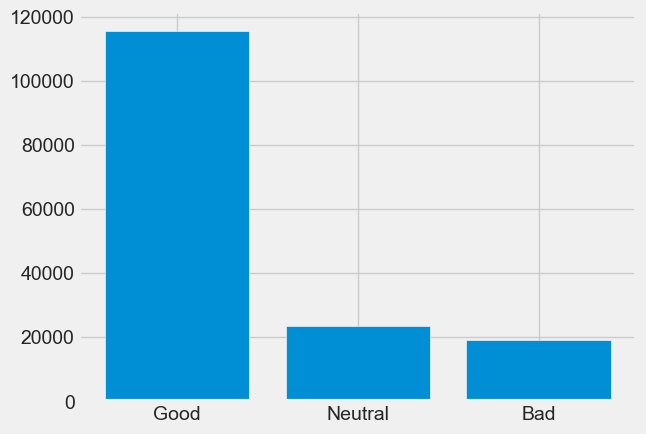

In [11]:
plt.bar(df_count['review_type_text'], df_count['count']);

<p style="font-size: xxx-large">Dataset is unbalanced.</p>

# Review's length

In [12]:
df['review_len'] = df['review_text'].apply(len)

In [13]:
review_lengths_dict = {}
for review_type, column_name in zip([-1, 0, 1], ['Negative reviews', 'Neutral reviews', 'Positive reviews']):
    review_lengths_dict[column_name] = df[df['review_type'] == review_type]['review_len'].describe()
pd.DataFrame(review_lengths_dict)

,Negative reviews,Neutral reviews,Positive reviews
count,19085.000000,23422.000000,115560.000000
mean,2490.339114,2400.898130,2424.600433
std,1366.668068,1400.709036,1386.084350
min,43.000000,71.000000,47.000000
25%,1502.000000,1396.000000,1426.000000
50%,2154.000000,2087.000000,2092.000000
75%,3159.000000,3099.000000,3098.000000
max,10076.000000,21334.000000,16237.000000


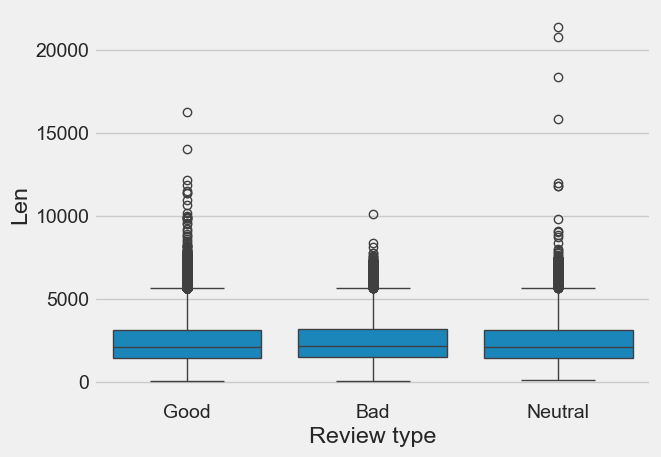

In [14]:
sns.boxplot(df, x='review_type_text', y='review_len').set(
    xlabel='Review type',
    ylabel='Len'
);

<p style="font-size: xxx-large">The number of characters in reviews of different types is approximately the same.</p>

# WordClouds

In [15]:
nltk.download('stopwords', quiet=True)
stopwords=set(nltk.corpus.stopwords.words('russian'))

In [16]:
def show_cloud(texts, height, width, background_color='white'):
    wc = WordCloud(stopwords=stopwords, background_color=background_color, random_state=42,
                   height=height, width=width)
    wc.generate(texts)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

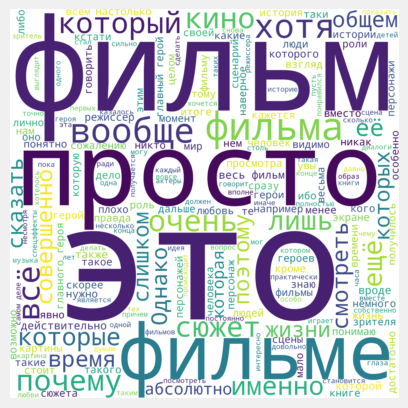

In [17]:
# Negative reviews
show_cloud(' '.join(df[df['review_type'] == -1]['review_text'][:]), 2000, 2000)

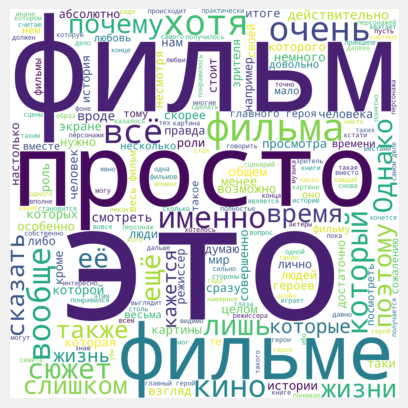

In [18]:
# Neutral reviews
show_cloud(' '.join(df[df['review_type'] == 0]['review_text'][:]), 2000, 2000)

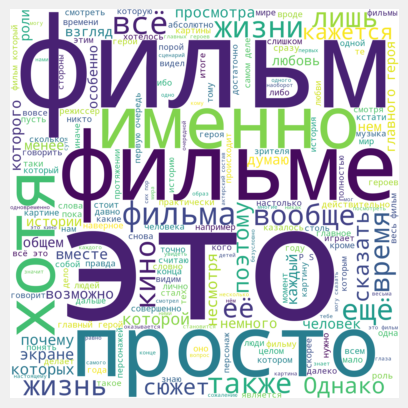

In [19]:
# Positive reviews
show_cloud(' '.join(df[df['review_type'] == 1]['review_text'][:]), 2000, 2000)

# Save DataFrame to data/interim folder

In [20]:
interim_path = os.path.join('..', 'data', 'interim')
if not os.path.exists(interim_path):
    os.makedirs(interim_path)
columns_to_save = ['film_id', 'review_title', 'review_text', 'review_len', 'review_type']
df[columns_to_save].to_csv(os.path.join(interim_path, 'reviews.csv'), index=False)

In [21]:
train_df, validate_df, test_df = train_validate_test_split(df[columns_to_save],
                                                           train_size=.8,
                                                           test_validate_ratio=1.0,
                                                           random_state=42,
                                                           stratify=df.review_type)
print(train_df.shape[0], validate_df.shape[0], test_df.shape[0])

126453 15807 15807


In [22]:
train_df.to_csv(os.path.join(interim_path, 'train_reviews.csv'), index=False)
validate_df.to_csv(os.path.join(interim_path, 'validate_reviews.csv'), index=False)
test_df.to_csv(os.path.join(interim_path, 'test_reviews.csv'), index=False)